In [1]:
import scipy.stats as stats
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import random
import sys
import corner
import pystan
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import pandas as pd

np.random.seed(1234)

# Question 8

In [2]:
a=91
b=9
print(stats.beta.mean(a,b))
print(stats.beta.std(a,b))
print(stats.beta.median(a,b))
print(stats.beta.ppf(0.025,a,b))
print(stats.beta.ppf(0.975,a,b))
print(stats.beta.pdf(0.832,a,b))
print(stats.beta.pdf(0.949,a,b))
print(stats.beta.cdf(0.949,a,b)-stats.beta.cdf(0.832,a,b))
print(stats.beta.interval(0.95,a,b))
hpdlow=0.85334
hpdhigh=0.96185
print(stats.beta.pdf(hpdlow,a,b)-stats.beta.pdf(hpdhigh,a,b))
print(stats.beta.cdf(hpdhigh,a,b)-stats.beta.cdf(hpdlow,a,b))

0.91
0.02847614947827235
0.9127300496553448
0.8469730200198541
0.9575835298814369
0.6399130415143535
6.413097881678375
0.9241342590765999
(0.8469730200198541, 0.9575835298814369)
-0.0006556934222432531
0.9500077807020534


# Question 13

In [2]:
# Set updata arrays
year=np.array([1900, 1904, 1906, 1908, 1912, 1920, 1924, 1928, 1932, 1936, 1948, 1952, 1956,1960,1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008])
jump=np.array([7.185, 7.340, 7.200, 7.480, 7.600, 7.150, 7.445, 7.730, 7.640, 8.060, 7.825, 7.570, 7.830, 8.120, 8.070, 8.900, 8.240, 8.350, 8.540, 8.540, 8.720, 8.670, 8.500 ,8.550, 8.590, 8.370])

lin_model_def = """
data {
  int npts;
  vector[npts] year;
  vector[npts] jump;
  
  real mu0;
  real var0;
  real a;
  real b;
}

parameters {
  real beta0;
  real beta1;
  real<lower=0> v;
}

model {
  for (i in 1:npts) {
        target+=normal_lpdf(jump[i] | beta0+beta1*year[i],sqrt(v));
  }
  target += normal_lpdf(beta0 | mu0, sqrt(var0));
  target += normal_lpdf(beta1 | mu0, sqrt(var0));
  target += inv_gamma_lpdf(v | a,b);
}
"""
lin_model = pystan.StanModel(model_code=lin_model_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_78043ea26f9038091fdbed2a7b9f887e NOW.


Inference for Stan model: anon_model_78043ea26f9038091fdbed2a7b9f887e.
4 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=36000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0 -19.32    0.03   2.92 -25.13 -21.23 -19.32 -17.38  -13.6  11107    1.0
beta1   0.01  1.4e-5 1.5e-3   0.01   0.01   0.01   0.01   0.02  11114    1.0
v       0.07  2.2e-4   0.02   0.04   0.05   0.07   0.08   0.12  10274    1.0
lp__  -12.98    0.01    1.3 -16.31 -13.55 -12.64 -12.04 -11.51   9228    1.0

Samples were drawn using NUTS at Wed Apr  1 15:50:46 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

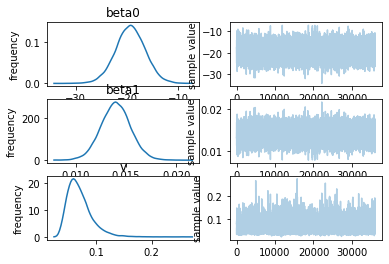

In [3]:
# Specify prior hyperparameters
# Priors on linear model coefficients.
mu0=0.
var0=1000.

# Prior on precision
a=0.1
b=0.1

# Define data array
lin_model_data = {'npts': len(jump),
            'year': year,
            'jump': jump,
            'mu0': mu0, 'var0': var0, 'a': a, 'b': b}


# Now get some samples from the posterior
lin_model_fit = lin_model.sampling(data=lin_model_data, iter=10000, chains=4, warmup=1000, thin=1, seed=101)

# Plot results 
lin_model_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
lin_model_fit

In [15]:
np.mean(lin_model_fit['beta1'])

0.013980703888063275

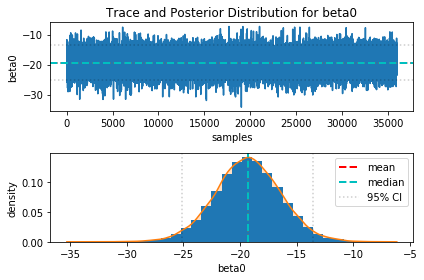

In [4]:
# Extract samples from fit for easier manipulation
summary_dict = lin_model_fit.summary()
lin_model_fit_dataframe = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# Plot trace plot and histogram of posterior samples for parameter 'param'
param='beta0'

cred_min, cred_max = np.percentile(lin_model_fit[param], 2.5), np.percentile(lin_model_fit[param], 97.5)
mean=np.mean(lin_model_fit[param])
median=np.median(lin_model_fit[param])

plt.subplot(2,1,1)
plt.plot(lin_model_fit[param])
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(lin_model_fit[param], 30, density=True); sns.kdeplot(lin_model_fit[param], shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()
plt.savefig("LongJumpFit_beta0.pdf")

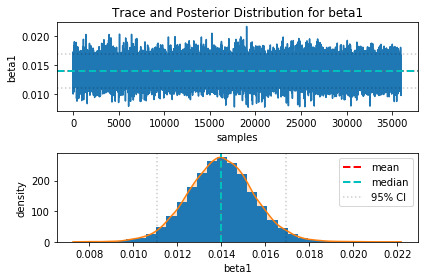

In [20]:
# Extract samples from fit for easier manipulation
summary_dict = lin_model_fit.summary()
lin_model_fit_dataframe = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# Plot trace plot and histogram of posterior samples for parameter 'param'
param='beta1'

cred_min, cred_max = np.percentile(lin_model_fit[param], 2.5), np.percentile(lin_model_fit[param], 97.5)
mean=np.mean(lin_model_fit[param])
median=np.median(lin_model_fit[param])

plt.subplot(2,1,1)
plt.plot(lin_model_fit[param])
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(lin_model_fit[param], 30, density=True); sns.kdeplot(lin_model_fit[param], shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()
plt.savefig("LongJumpFit_beta1.pdf")

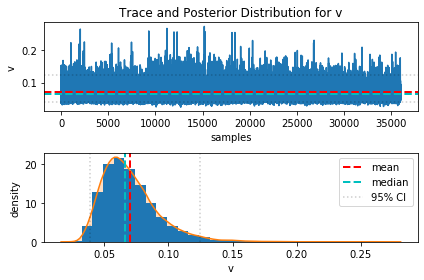

In [21]:
# Extract samples from fit for easier manipulation
summary_dict = lin_model_fit.summary()
lin_model_fit_dataframe = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# Plot trace plot and histogram of posterior samples for parameter 'param'
param='v'

cred_min, cred_max = np.percentile(lin_model_fit[param], 2.5), np.percentile(lin_model_fit[param], 97.5)
mean=np.mean(lin_model_fit[param])
median=np.median(lin_model_fit[param])

plt.subplot(2,1,1)
plt.plot(lin_model_fit[param])
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(lin_model_fit[param], 30, density=True); sns.kdeplot(lin_model_fit[param], shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()
plt.savefig("LongJumpFit_v.pdf")

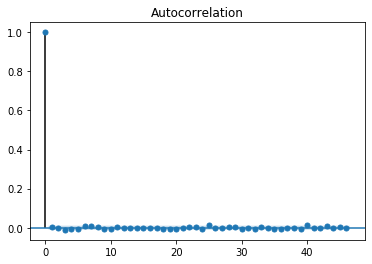

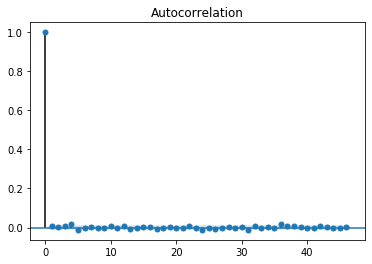

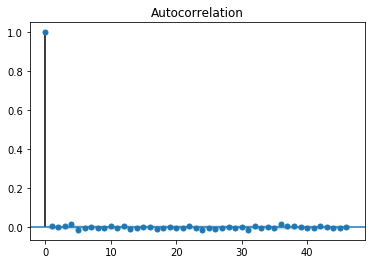

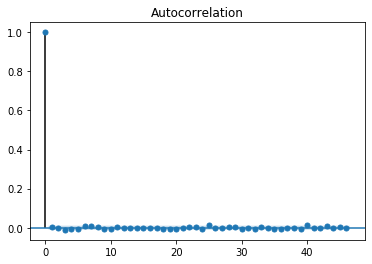

In [5]:
plot_acf(lin_model_fit['beta0'])
plot_acf(lin_model_fit['beta1'])
plot_acf(lin_model_fit['v'])

In [10]:
len(lin_model_fit['beta0'])

39000

Inference for Stan model: anon_model_78043ea26f9038091fdbed2a7b9f887e.
4 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=36000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0   8.01  3.7e-4   0.05   7.91   7.97   8.01   8.04   8.11  19145    1.0
beta1   0.01  7.1e-6 1.5e-3   0.01   0.01   0.01   0.02   0.02  45858    1.0
v       0.07  1.7e-4   0.02   0.04   0.05   0.07   0.08   0.12  17484    1.0
lp__  -12.82    0.01   1.28 -16.14  -13.4 -12.49 -11.88 -11.35  14096    1.0

Samples were drawn using NUTS at Fri Feb 21 15:55:58 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

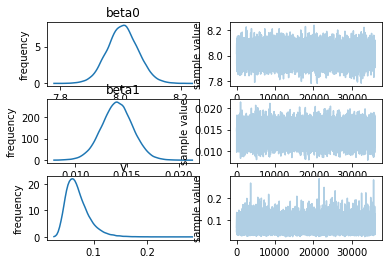

In [27]:
# Specify prior hyperparameters
# Priors on linear model coefficients.
mu0=0.
var0=1000.

# Prior on precision
a=0.1
b=0.1

year_cent=year-np.mean(year)

# Define data array
lin_cent_model_data = {'npts': len(jump),
            'year': year_cent,
            'jump': jump,
            'mu0': mu0, 'var0': var0, 'a': a, 'b': b}


# Now get some samples from the posterior
lin_cent_model_fit = lin_model.sampling(data=lin_cent_model_data, iter=10000, chains=4, warmup=1000, thin=1, seed=101)

# Plot results 
lin_cent_model_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
lin_cent_model_fit

In [28]:
print(np.mean(lin_model_fit['beta1']))
print(np.mean(lin_cent_model_fit['beta1']))

0.013980703888063275
0.01405680740835289


In [29]:
lin_model_robust_def = """
data {
  int npts;
  vector[npts] year;
  vector[npts] jump;
  
  real mu0;
  real var0;
  real a;
  real b;
  real nu;
}

parameters {
  real beta0;
  real beta1;
  real<lower=0> v;
}

model {
  for (i in 1:npts) {
        target+=student_t_lpdf(jump[i] | nu, beta0+beta1*year[i],sqrt(v));
  }
  target += normal_lpdf(beta0 | mu0, sqrt(var0));
  target += normal_lpdf(beta1 | mu0, sqrt(var0));
  target += inv_gamma_lpdf(v | a,b);
}
"""
lin_model_robust = pystan.StanModel(model_code=lin_model_robust_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b4ddc5e55a66d2f8ae7bba085d048a6 NOW.


Inference for Stan model: anon_model_0b4ddc5e55a66d2f8ae7bba085d048a6.
4 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=36000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0    8.0  3.5e-4   0.05   7.91   7.97    8.0   8.03   8.09  18204    1.0
beta1   0.01  6.4e-6 1.3e-3   0.01   0.01   0.01   0.01   0.02  44428    1.0
v       0.04  1.3e-4   0.02   0.02   0.03   0.04   0.05   0.09  17361    1.0
lp__  -13.12    0.01   1.29  -16.5  -13.7 -12.79 -12.18 -11.65  13766    1.0

Samples were drawn using NUTS at Mon Feb 24 11:56:01 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

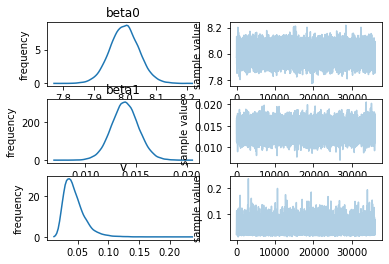

In [30]:
# Specify prior hyperparameters
# Priors on linear model coefficients.
mu0=0.
var0=1000.

# Prior on precision
a=0.1
b=0.1

# Degrees of freedom of student-t
nu=3

# Define data array
lin_cent_model_robust_data = {'npts': len(jump),
            'year': year_cent,
            'jump': jump,
            'mu0': mu0, 'var0': var0, 'a': a, 'b': b, 'nu': nu}


# Now get some samples from the posterior
lin_cent_model_robust_fit = lin_model_robust.sampling(data=lin_cent_model_robust_data, iter=10000, chains=4, warmup=1000, thin=1, seed=101)

# Plot results 
lin_cent_model_robust_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
lin_cent_model_robust_fit

In [31]:
lin_model_robustB_def = """
data {
  int npts;
  vector[npts] year;
  vector[npts] jump;
  
  real mu0;
  real var0;
  real a;
  real b;
  real c;
  real d;
}

parameters {
  real beta0;
  real beta1;
  real<lower=0> v;
  real nu;
}

model {
  for (i in 1:npts) {
        target+=student_t_lpdf(jump[i] | nu, beta0+beta1*year[i],sqrt(v));
  }
  target += normal_lpdf(beta0 | mu0, sqrt(var0));
  target += normal_lpdf(beta1 | mu0, sqrt(var0));
  target += inv_gamma_lpdf(v | a,b);
  target += gamma_lpdf(nu |c,d);
}
"""
lin_model_robustB = pystan.StanModel(model_code=lin_model_robustB_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49868e6866fd7c5f2683007cb8c8dc84 NOW.


Inference for Stan model: anon_model_49868e6866fd7c5f2683007cb8c8dc84.
4 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=36000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0    8.0  4.5e-4   0.05   7.91   7.97    8.0   8.03    8.1  11482    1.0
beta1   0.01  7.5e-6 1.4e-3   0.01   0.01   0.01   0.01   0.02  35027    1.0
v       0.05  2.1e-4   0.02   0.02   0.04   0.05   0.06    0.1   9020    1.0
nu      7.92    0.11   6.62   1.67   3.66    5.9   9.84  26.08   3514    1.0
lp__  -17.75    0.02   1.66 -21.86 -18.61 -17.39 -16.52 -15.62   5576    1.0

Samples were drawn using NUTS at Mon Feb 24 11:56:47 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

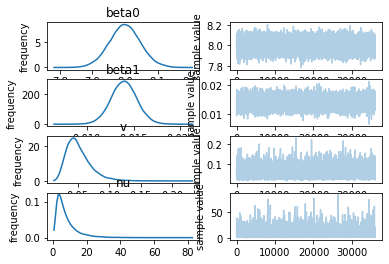

In [32]:
# Specify prior hyperparameters
# Priors on linear model coefficients.
mu0=0.
var0=1000.

# Prior on precision
a=0.1
b=0.1
c=0.1
d=0.1

# Define data array
lin_cent_model_robustB_data = {'npts': len(jump),
            'year': year_cent,
            'jump': jump,
            'mu0': mu0, 'var0': var0, 'a': a, 'b': b, 'c': c, 'd': d}


# Now get some samples from the posterior
lin_cent_model_robustB_fit = lin_model_robustB.sampling(data=lin_cent_model_robustB_data, iter=10000, chains=4, warmup=1000, thin=1, seed=101)

# Plot results 
lin_cent_model_robustB_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
lin_cent_model_robustB_fit

In [34]:
print(np.mean(lin_cent_model_robust_fit['beta1']))
print(np.mean(lin_cent_model_robustB_fit['beta1']))

0.013928924676996959
0.013962250394141066


# Question 14

In [58]:
normal_model_def = """
data {
  int npts;
  vector[npts] y;
  vector[2] wt;
  
  real mu1;
  real var1;
  real mu2;
  real var2;
  real a;
  real b;
}

parameters {
  real mu;
  real<lower=0> v;
}

model {
  for (i in 1:npts) {
        target+=normal_lpdf(y[i] | mu,sqrt(v));
  }
  target += log(exp(log(wt[1])+normal_lpdf(mu | mu1,sqrt(var1)))+exp(log(wt[2])+normal_lpdf(mu | mu2,sqrt(var2))));
  target += inv_gamma_lpdf(v | a,b);
}

generated quantities {
   real sigma;
   real frac;
   real ynew;
   real prob;
   sigma = sqrt(v);
   if (mu < 1)
       frac=1;
   else
       frac=0;
   ynew=normal_rng(mu,sigma);
   if (ynew < 0)
       prob=1;
   else
       prob=0;
}

"""
normal_model = pystan.StanModel(model_code=normal_model_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_57783935c2c5298103b8af00549faf2d NOW.


Inference for Stan model: anon_model_57783935c2c5298103b8af00549faf2d.
4 chains, each with iter=50000; warmup=1000; thin=1; 
post-warmup draws per chain=49000, total post-warmup draws=196000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.24  3.4e-3   0.72   0.14   0.81   1.17   1.54   3.29  45941    1.0
v      13.71    0.03   8.04   5.24   8.67   11.7  16.34  33.95  68857    1.0
sigma   3.59  3.4e-3   0.92   2.29   2.95   3.42   4.04   5.83  74182    1.0
frac    0.37  1.2e-3   0.48    0.0    0.0    0.0    1.0    1.0 164886    1.0
ynew    1.24  9.0e-3   3.77  -6.29  -1.11   1.24   3.59   8.78 177236    1.0
prob    0.36  1.1e-3   0.48    0.0    0.0    0.0    1.0    1.0 192118    1.0
lp__  -32.61  5.7e-3   1.19 -35.83 -33.02 -32.21 -31.77 -31.48  43247    1.0

Samples were drawn using NUTS at Tue Feb 25 21:54:33 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split ch

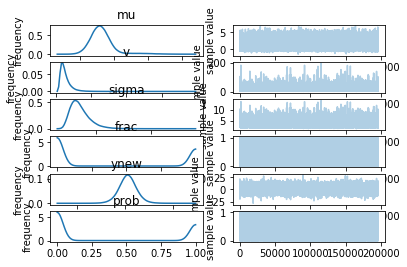

In [63]:
# Data
npts=10
y=np.array([-0.566,  3.74,  5.55, -1.90, -3.54, 5.16, -1.76, 4.08, 4.62, 0.732])

# Specify prior hyperparameters
# Priors on linear model coefficients.
mu1=1.
var1=1.0/3.0
mu2=5.0
var2=4./3.

wt=np.array([2./3.,1./3.])
# Prior on precision
a=0.01
b=0.01

# Define data array
normal_model_data = {'npts': npts,
            'y': y,
            'wt': wt,
            'mu1': mu1, 'var1': var1, 'mu2': mu2, 'var2': var2, 'a': a, 'b': b}


# Now get some samples from the posterior
normal_model_fit = normal_model.sampling(data=normal_model_data, iter=50000, chains=4, warmup=1000, thin=1, seed=101)

# Plot results 
normal_model_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
normal_model_fit

In [64]:
print(np.mean(normal_model_fit['frac']))
print(np.mean(normal_model_fit['prob']))

0.37494387755102043
0.35954591836734695


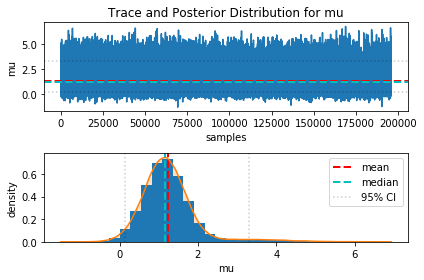

In [65]:
# Extract samples from fit for easier manipulation
summary_dict = normal_model_fit.summary()
normal_model_fit_dataframe = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# Plot trace plot and histogram of posterior samples for parameter 'param'
param='mu'

cred_min, cred_max = np.percentile(normal_model_fit[param], 2.5), np.percentile(normal_model_fit[param], 97.5)
mean=np.mean(normal_model_fit[param])
median=np.median(normal_model_fit[param])

plt.subplot(2,1,1)
plt.plot(normal_model_fit[param])
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(normal_model_fit[param], 30, density=True); sns.kdeplot(normal_model_fit[param], shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()
plt.savefig("NormalNormalModelFit_mu.pdf")

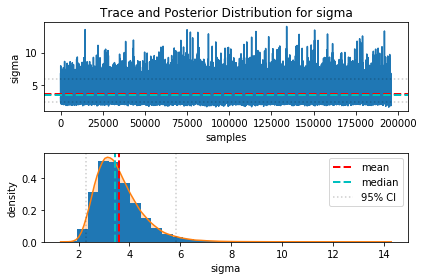

In [66]:
# Extract samples from fit for easier manipulation
summary_dict = normal_model_fit.summary()
normal_model_fit_dataframe = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# Plot trace plot and histogram of posterior samples for parameter 'param'
param='sigma'

cred_min, cred_max = np.percentile(normal_model_fit[param], 2.5), np.percentile(normal_model_fit[param], 97.5)
mean=np.mean(normal_model_fit[param])
median=np.median(normal_model_fit[param])

plt.subplot(2,1,1)
plt.plot(normal_model_fit[param])
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(normal_model_fit[param], 30, density=True); sns.kdeplot(normal_model_fit[param], shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()
plt.savefig("NormalNormalModelFit_sigma.pdf")

In [71]:
normal_model_varywt_def = """
data {
  int npts;
  vector[npts] y;
  real<lower=0> v;

  real mu1;
  real var1;
  real mu2;
  real var2;
  real a;
  real b;
}

parameters {
  real mu;
  real<lower=0, upper=1> wt;
}

model {
  for (i in 1:npts) {
        target+=normal_lpdf(y[i] | mu,sqrt(v));
  }
  target += log(exp(log(wt)+normal_lpdf(mu | mu1,sqrt(var1)))+exp(log(1.0-wt)+normal_lpdf(mu | mu2,sqrt(var2))));
}

generated quantities {
   real sigma;
   real frac;
   real ynew;
   real prob;
   sigma = sqrt(v);
   if (mu < 1)
       frac=1;
   else
       frac=0;
   ynew=normal_rng(mu,sigma);
   if (ynew < 0)
       prob=1;
   else
       prob=0;
}

"""
normal_model_varywt = pystan.StanModel(model_code=normal_model_varywt_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d06e3bf44a98aecd804abca0ef629094 NOW.


Inference for Stan model: anon_model_d06e3bf44a98aecd804abca0ef629094.
4 chains, each with iter=100000; warmup=1000; thin=1; 
post-warmup draws per chain=99000, total post-warmup draws=396000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.63  7.4e-3   1.32   0.04   0.79   1.23   1.87   5.05  31979    1.0
wt       0.6  9.9e-4   0.27   0.06    0.4   0.64   0.83   0.98  74003    1.0
sigma   5.48 4.4e-156.2e-15   5.48   5.48   5.48   5.48   5.48      2    1.0
frac    0.37  1.3e-3   0.48    0.0    0.0    0.0    1.0    1.0 140954    1.0
ynew    1.62    0.01   5.64   -9.4  -2.18   1.61   5.43  12.71 255306    1.0
prob    0.39  8.8e-4   0.49    0.0    0.0    0.0    1.0    1.0 303917    1.0
lp__  -31.69  5.6e-3   1.27 -34.76 -32.48 -31.31 -30.66 -30.29  51918    1.0

Samples were drawn using NUTS at Fri Feb 28 12:37:47 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split c

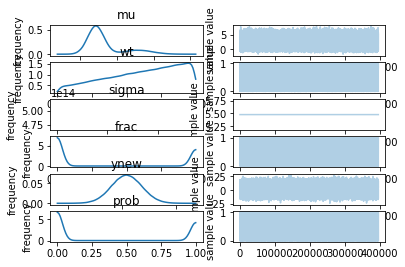

In [72]:
# Data
npts=10
y=np.array([-0.566,  3.74,  5.55, -1.90, -3.54, 5.16, -1.76, 4.08, 4.62, 0.732])
v=30.0

# Specify prior hyperparameters
# Priors on linear model coefficients.
mu1=1.
var1=1.0/3.0
mu2=5.0
var2=4./3.

# Prior on precision
a=0.01
b=0.01

# Define data array
normal_model_varywt_data = {'npts': npts,
            'y': y,
            'v': v,
            'mu1': mu1, 'var1': var1, 'mu2': mu2, 'var2': var2, 'a': a, 'b': b}


# Now get some samples from the posterior
normal_model_varywt_fit = normal_model_varywt.sampling(data=normal_model_varywt_data, iter=100000, chains=4, warmup=1000, thin=1, seed=101)

# Plot results 
normal_model_varywt_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
normal_model_varywt_fit

In [68]:
# Now check what happens if the variance is unknown.
normal_model_varywt_def = """
data {
  int npts;
  vector[npts] y;
  
  real mu1;
  real var1;
  real mu2;
  real var2;
  real a;
  real b;
}

parameters {
  real mu;
  real<lower=0> v;
  real<lower=0, upper=1> wt;
}

model {
  for (i in 1:npts) {
        target+=normal_lpdf(y[i] | mu,sqrt(v));
  }
  target += log(exp(log(wt)+normal_lpdf(mu | mu1,sqrt(var1)))+exp(log(1.0-wt)+normal_lpdf(mu | mu2,sqrt(var2))));
  target += inv_gamma_lpdf(v | a,b);
}

generated quantities {
   real sigma;
   real frac;
   real ynew;
   real prob;
   sigma = sqrt(v);
   if (mu < 1)
       frac=1;
   else
       frac=0;
   ynew=normal_rng(mu,sigma);
   if (ynew < 0)
       prob=1;
   else
       prob=0;
}

"""
normal_model_varywt = pystan.StanModel(model_code=normal_model_varywt_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eb88464a92584949624d029551ae504e NOW.


Inference for Stan model: anon_model_eb88464a92584949624d029551ae504e.
4 chains, each with iter=100000; warmup=1000; thin=1; 
post-warmup draws per chain=99000, total post-warmup draws=396000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.35  3.1e-3   0.87   0.16   0.84   1.21   1.62   3.98  79084    1.0
v      13.96    0.02   8.38   5.29   8.74  11.85  16.56  35.31 172079    1.0
wt      0.63  6.0e-4   0.26   0.09   0.45   0.68   0.85   0.99 182110    1.0
sigma   3.61  2.2e-3   0.95    2.3   2.96   3.44   4.07   5.94 187771    1.0
frac    0.35  8.2e-4   0.48    0.0    0.0    0.0    1.0    1.0 336370    1.0
ynew    1.36  6.7e-3   3.84  -6.22  -1.04   1.33   3.72   9.08 326667    1.0
prob    0.35  7.8e-4   0.48    0.0    0.0    0.0    1.0    1.0 370657    1.0
lp__   -34.8  4.9e-3    1.5 -38.54 -35.59 -34.38 -33.67 -33.08  93627    1.0

Samples were drawn using NUTS at Wed Feb 26 15:41:55 2020.
For each parameter, n_eff is a crude measure of effec

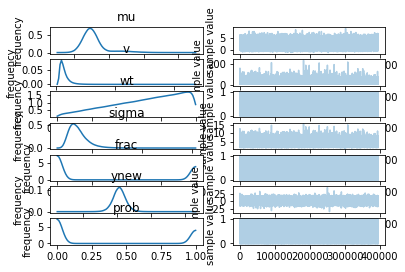

In [70]:
# Data
npts=10
y=np.array([-0.566,  3.74,  5.55, -1.90, -3.54, 5.16, -1.76, 4.08, 4.62, 0.732])

# Specify prior hyperparameters
# Priors on linear model coefficients.
mu1=1.
var1=1.0/3.0
mu2=5.0
var2=4./3.

# Prior on precision
a=0.01
b=0.01

# Define data array
normal_model_varywt_data = {'npts': npts,
            'y': y,
            'mu1': mu1, 'var1': var1, 'mu2': mu2, 'var2': var2, 'a': a, 'b': b}


# Now get some samples from the posterior
normal_model_varywt_fit = normal_model_varywt.sampling(data=normal_model_varywt_data, iter=100000, chains=4, warmup=1000, thin=1, seed=101)

# Plot results 
normal_model_varywt_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
normal_model_varywt_fit